In [1]:
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

### Master Thesis: EigenGARCH(2021)
We consider the new multivariate Dynamic Conditional Eigenvalue GARCH model (λ-MGARCH) introduced in Hetland et al. (2022 JoE). We are interested in evaluating its ability to forecast conditional covariance matrices, relative to competing multivariate GARCH models for time- varying conditional covariance matrice

### Initial Estimation

In [2]:
# Import Packages
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.special import gamma
from scipy.stats import stats
from matplotlib import pyplot as plt 
import statsmodels.api as sm
import statsmodels as sms
import yfinance as yf
from numpy.linalg import eig

import Eigen_GARCH as Eigen_GARCH

#### Import Data

In [3]:
# Use the exact same data as in R, for the DCC and GO-GARCH model
data = np.array(pd.read_csv("returns_R_simple.csv")).T

#### Estimate

In [4]:
# Set up bounds and lambdas
covdata = np.cov(data,bias=True)
T = data.shape[1]
k = 3
eigenvalues, eigenvectors = eig(covdata)
lambdas_eig = eigenvalues
bnds = [(-np.pi/2, np.pi/2)]
bnds_eig = [(0, np.pi)]

for i in range(2*(k**2)+k+2):
    bnds_eig.append((0, 100))

# Initial values
arguments_eig = (np.asarray(data),lambdas_eig)
startingVals_eig = [np.random.uniform(0.01,0.2) for i in range(2*(k**2) + k + 3)]

# Estimation
estimation = minimize(Eigen_GARCH.eigenLikelihood , x0=startingVals_eig , 
                          args=arguments_eig , method="SLSQP", bounds=bnds_eig, 
                          options={"maxiter":100000, "ftol":10e-14})

In [5]:
# Save the estimated parameter values
phi1_eig, phi2_eig, phi3_eig, w1_eig, w2_eig, w3_eig , a11_eig , a12_eig , a13_eig, a21_eig , a22_eig, a23_eig, a31_eig , a32_eig, a33_eig , b11_eig , b12_eig, b13_eig , b21_eig , b22_eig, b23_eig, b31_eig , b32_eig, b33_eig = estimation.x

# Find the llh and information criteria for the Eigen GARCH
llh = - estimation.fun
AIC = 2 * 24 - 2 * (llh)
BIC = - 2 * llh + np.log(T) * 24

# Load into matrices
W_eig = np.array(([w1_eig], [w2_eig], [w3_eig]))
A_eig = np.array(([a11_eig, a12_eig, a13_eig],
                  [a21_eig, a22_eig, a23_eig],
                  [a31_eig, a32_eig, a33_eig]))
B_eig = np.array(([b11_eig, b12_eig, b13_eig],
                  [b21_eig, b22_eig, b23_eig],
                  [b31_eig, b32_eig, b33_eig]))
V_eig = np.array(([np.cos(phi1_eig), np.sin(phi1_eig),0], [-np.sin(phi1_eig), np.cos(phi1_eig),0 ], [0, 0,1 ])
                )@ np.array(([np.cos(phi2_eig), 0, np.sin(phi2_eig)], [0, 1,0 ], [-np.sin(phi2_eig), 0, np.cos(phi2_eig)])
                           )@ np.array(( [1, 0,0 ], [0,np.cos(phi3_eig), np.sin(phi3_eig)], [0,-np.sin(phi3_eig), np.cos(phi3_eig)]))

print(f'W: {W_eig}')
print(f'A: {A_eig}')
print(f'B: {B_eig}')
print(f'V: {V_eig}')
print(f'Log-likelihood: {llh}')
print(f'AIC: {AIC/T}')
print(f'BIC: {BIC/T}')

W: [[0.21730393]
 [0.01032544]
 [0.05539968]]
A: [[0.13759525 0.07981789 0.05539718]
 [0.03681774 0.08048966 0.01332934]
 [0.00778359 0.00732746 0.10580898]]
B: [[2.22932884e-01 1.08390893e-01 6.86369464e-12]
 [4.80910657e-12 9.05500714e-01 9.38033123e-08]
 [2.78109903e-11 2.79821720e-03 8.03891918e-01]]
V: [[ 5.41575693e-01  8.39580418e-01  4.24321891e-02]
 [-8.37015279e-01  5.43235420e-01 -6.55797341e-02]
 [-7.81101287e-02 -6.35697966e-10  9.96944737e-01]]
Log-likelihood: -12653.13032864371
AIC: 11.21373757509395
BIC: 11.274491887050903


In [6]:
p,T=data.shape 
Xtilde = V_eig.transpose() @ data
lambdas = (np.ones((T,p))).transpose()
residuals = (np.ones((T,p))).transpose()
for t in range(1,T):
    lambdas[:,t:t+1] = W_eig + A_eig @ np.multiply(Xtilde[:,t-1:t],Xtilde[:,t-1:t]) + B_eig @ lambdas[:,t-1:t]
    evalues, evectors = np.linalg.eig(np.diag(np.concatenate(lambdas[:,t:t+1])))
    sqrt_matrix = evectors @ np.diag(np.sqrt(evalues)) @ np.linalg.inv(evectors)
    residuals[:,t:t+1] = np.vstack(np.diag(np.multiply(np.sqrt(1/np.diag(np.concatenate(lambdas[:,t:t+1]))),Xtilde[:,t-1:t])))

In [7]:
# Misspisification test
print(stats.jarque_bera(residuals[0]))
print(stats.jarque_bera(residuals[1]))
print(stats.jarque_bera(residuals[2]))

Jarque_beraResult(statistic=7.643400290858173, pvalue=0.021890552116942796)
Jarque_beraResult(statistic=1.529278143413761, pvalue=0.4655019134687445)
Jarque_beraResult(statistic=3.9482920589265924, pvalue=0.1388798609265821)


In [8]:
# Skewness
print(stats.skew(residuals[0], axis=0, bias=True))
print(stats.skew(residuals[1], axis=0, bias=True))
print(stats.skew(residuals[2], axis=0, bias=True))

-0.04078264472089768
0.03882869505082233
0.04745419015889151


In [9]:
# Kurtosis
print(stats.kurtosis(residuals[0], axis=0, bias=True))
print(stats.kurtosis(residuals[1], axis=0, bias=True))
print(stats.kurtosis(residuals[2], axis=0, bias=True))

-0.27291034547591453
-0.10100628160227743
-0.18139079421919746


In [10]:
# Save results 
df = pd.DataFrame(residuals[0])
df.to_csv('eig_residuals_jpm.csv') 

df = pd.DataFrame(residuals[1])
df.to_csv('eig_residuals_msft.csv') 

df = pd.DataFrame(residuals[2])
df.to_csv('eig_residuals_ko.csv')

In [11]:
# Calculate the covariance matrices based on the estimated values
Xtilde = V_eig.transpose() @ data
lambdas = (np.ones((T,k))).transpose()
condVar_eig = np.zeros((T,k,k))

for t in range(1,T):
    lambdas[:,t:t+1] = W_eig + A_eig @ np.multiply(Xtilde[:,t-1:t],Xtilde[:,t-1:t]) + B_eig @ lambdas[:,t-1:t]
    condVar_eig[t] = V_eig @ np.diag(np.concatenate(lambdas[:,t:t+1],axis= None)) @ V_eig.transpose()

# Make a list for each of the covariance pairs
cov_JPM_MSFT = []
for t in range(0,T):
    cov_JPM_MSFT.append(condVar_eig[t][0][1])

cov_JPM_KO = []
for t in range(0,T):
    cov_JPM_KO.append(condVar_eig[t][0][2])

cov_KO_MSFT = []
for t in range(0,T):
    cov_KO_MSFT.append(condVar_eig[t][1][2])


In [12]:
# Save results 
df = pd.DataFrame(cov_JPM_KO)
df.to_csv('cov_JPM_KO_eigen.csv') 

df = pd.DataFrame(cov_JPM_MSFT)
df.to_csv('cov_JPM_MSFT_eigen.csv') 

df = pd.DataFrame(cov_KO_MSFT)
df.to_csv('cov_KO_MSFT_eigen.csv')


### Pre period

In [99]:
# Use the exact same data as in R, for the DCC and GO-GARCH model
data_pre = np.array(pd.read_csv("returns_R_pre_crisis.csv")).T

In [100]:
# Set up bounds and lambdas
covdata = np.cov(data_pre,bias=True)
T = data_pre.shape[1]
k = 3
eigenvalues, eigenvectors = eig(covdata)
lambdas_eig = eigenvalues
bnds = [(-np.pi/2, np.pi/2)]
bnds_eig = [(0, np.pi)]

for i in range(2*(k**2)+k+2):
    bnds_eig.append((0, 100))

# Initial values
arguments_eig = (np.asarray(data_pre),lambdas_eig)
startingVals_eig = [np.random.uniform(0.01,0.2) for i in range(2*(k**2) + k + 3)]

# Estimation
estimation = minimize(Eigen_GARCH.eigenLikelihood , x0=startingVals_eig , 
                          args=arguments_eig , method="SLSQP", bounds=bnds_eig, 
                          options={"maxiter":100000, "ftol":10e-14})

In [101]:
# Save the estimated parameter values
phi1_eig, phi2_eig, phi3_eig, w1_eig, w2_eig, w3_eig , a11_eig , a12_eig , a13_eig, a21_eig , a22_eig, a23_eig, a31_eig , a32_eig, a33_eig , b11_eig , b12_eig, b13_eig , b21_eig , b22_eig, b23_eig, b31_eig , b32_eig, b33_eig = estimation.x

# Find the llh and information criteria for the Eigen GARCH
llh = - estimation.fun
AIC = 2 * 24 - 2 * (llh)
BIC = - 2 * llh + np.log(T) * 24

# Load into matrices
W_eig = np.array(([w1_eig, w2_eig, w3_eig]))
A_eig = np.array(([a11_eig, a12_eig, a13_eig],[a21_eig, a22_eig, a23_eig],[a31_eig, a32_eig, a33_eig]))
B_eig = np.array(([b11_eig, b12_eig, b13_eig],[b21_eig, b22_eig, b23_eig],[b31_eig, b32_eig, b33_eig]))
V_eig = np.array(([np.cos(phi1_eig), np.sin(phi1_eig),0], [-np.sin(phi1_eig), np.cos(phi1_eig),0 ], [0, 0,1 ]))@ np.array(([np.cos(phi2_eig), 0, np.sin(phi2_eig)], [0, 1,0 ], [-np.sin(phi2_eig), 0, np.cos(phi2_eig)]))@ np.array(( [1, 0,0 ], [0,np.cos(phi3_eig), np.sin(phi3_eig)], [0,-np.sin(phi3_eig), np.cos(phi3_eig)]))

print(f'Log-likelihood: {llh}')
print(f'AIC: {AIC/T}')
print(f'BIC: {BIC/T}')

Log-likelihood: -9028.06958217207
AIC: 10.309874239375933
BIC: 10.384645908271537


### Post period

In [16]:
# Use the exact same data as in R, for the DCC and GO-GARCH model
data_post = np.array(pd.read_csv("returns_R_crisis.csv")).T

In [17]:
# Set up bounds and lambdas
covdata = np.cov(data_post,bias=True)
T = data_post.shape[1]
k = 3
eigenvalues, eigenvectors = eig(covdata)
lambdas_eig = eigenvalues
bnds = [(-np.pi/2, np.pi/2)]
bnds_eig = [(0, np.pi)]

for i in range(2*(k**2)+k+2):
    bnds_eig.append((0, 100))

# Initial values
arguments_eig = (np.asarray(data_post),lambdas_eig)
startingVals_eig = [np.random.uniform(0.01,0.2) for i in range(2*(k**2) + k + 3)]

# Estimation
estimation = minimize(Eigen_GARCH.eigenLikelihood , x0=startingVals_eig , 
                          args=arguments_eig , method="SLSQP", bounds=bnds_eig, 
                          options={"maxiter":100000, "ftol":10e-14})

In [18]:
# Save the estimated parameter values
phi1_eig, phi2_eig, phi3_eig, w1_eig, w2_eig, w3_eig , a11_eig , a12_eig , a13_eig, a21_eig , a22_eig, a23_eig, a31_eig , a32_eig, a33_eig , b11_eig , b12_eig, b13_eig , b21_eig , b22_eig, b23_eig, b31_eig , b32_eig, b33_eig = estimation.x

# Find the llh and information criteria for the Eigen GARCH
llh = - estimation.fun
AIC = 2 * 24 - 2 * (llh)
BIC = - 2 * llh + np.log(T) * 24

# Load into matrices
W_eig = np.array(([w1_eig, w2_eig, w3_eig]))
A_eig = np.array(([a11_eig, a12_eig, a13_eig],[a21_eig, a22_eig, a23_eig],[a31_eig, a32_eig, a33_eig]))
B_eig = np.array(([b11_eig, b12_eig, b13_eig],[b21_eig, b22_eig, b23_eig],[b31_eig, b32_eig, b33_eig]))
V_eig = np.array(([np.cos(phi1_eig), np.sin(phi1_eig),0], [-np.sin(phi1_eig), np.cos(phi1_eig),0 ], [0, 0,1 ]))@ np.array(([np.cos(phi2_eig), 0, np.sin(phi2_eig)], [0, 1,0 ], [-np.sin(phi2_eig), 0, np.cos(phi2_eig)]))@ np.array(( [1, 0,0 ], [0,np.cos(phi3_eig), np.sin(phi3_eig)], [0,-np.sin(phi3_eig), np.cos(phi3_eig)]))

print(f'Log-likelihood: {llh}')
print(f'AIC: {AIC/T}')
print(f'BIC: {BIC/T}')

Log-likelihood: -3488.6600201733627
AIC: 13.93912706418001
BIC: 14.140202124564361


### Forecast

In [142]:
# Use the exact same data as in R, for the DCC and GO-GARCH model
data_forecast = data

In [143]:
# Number of loops in forecast
p = 3
N = 756

# Create covariance matrix container
forecastMatrix_eig = np.zeros((N,p,p))

In [155]:
for n in range(N):
    # Move estimation window by 5
    X = data_forecast[:,n:1505+n]
    print(n, "out of", N, "in Eigen-GARCH forecasting")
    
    # Generate new lambdas for likelihood estimation
    lambdas_eig = np.tile(np.linalg.eig(np.cov(X.T, rowvar=False))[0], (T,1))

    # Initial values
    arguments_eig = (np.asarray(data_pre),lambdas_eig)
    
    # Use prior estimation results as starting values
    startingVals_eig = list(estimation.x)
    
    # Arguments
    arguments_eig = (np.asarray(X), lambdas_eig)
    
    # Estimation
    estimation = minimize(Eigen_GARCH.eigenLikelihood, x0=startingVals_eig , args=arguments_eig , method="SLSQP", bounds=bnds_eig, options={"maxiter":100000, "ftol":10e-24})
    
    # Save parameters
    phi1, phi2, phi3, w1, w2, w3, a11, a12, a13, a21, a22, a23, a31, a32, a33, b11, b12, b13, b21, b22,b23, b31, b32,b33 = estimation.x
 
    W_eig = np.array(([w1, w2, w3]))
    A_eig = np.array(([a11, a12,a13],
                  [a21, a22,a23],
                  [a31, a32,a33]))
    B_eig = np.array(([b11, b12,b13],
                  [b21, b22,b23],
                  [b31, b32,b33]))
    V_eig = np.array(([np.cos(phi1), np.sin(phi1),0],[-np.sin(phi1), np.cos(phi1),0 ], [0, 0,1 ])
                    )@ np.array(([np.cos(phi2), 0, np.sin(phi2)], [0, 1,0 ], [-np.sin(phi2), 0, np.cos(phi2)])
                           )@ np.array(( [1, 0,0 ], [0,np.cos(phi3), np.sin(phi3)], [0,-np.sin(phi3), np.cos(phi3)]))
    
    # Conditional eigenvalue at time t+1
    Xtilde = V_eig.transpose() @ X
    T = 1505
    
    lambdas = (np.ones((k,T))).transpose()
    condVar_eig = np.zeros((T,k,k))
    
    for t in range(1,T):
        lambdas[t] = W_eig+np.concatenate(A_eig @ np.multiply(Xtilde[:,t-1:t],Xtilde[:,t-1:t]), axis=0 )+ B_eig @ lambdas[t-1]
        condVar_eig[t] = V_eig @ np.diag(lambdas[t]) @ V_eig.T
         
    # Conditional eigenvalue at time t+1
    lambdas_f = W_eig + (A_eig @ np.multiply(Xtilde[:,T-1], Xtilde[:,T-1]))+ B_eig @ lambdas[T-1]
 
    # Store 1-step forecast
    forecastMatrix_eig[n,:,:] = V_eig @ np.diag(lambdas_f) @ V_eig.T

0 out of 756 in Eigen-GARCH forecasting
1 out of 756 in Eigen-GARCH forecasting
2 out of 756 in Eigen-GARCH forecasting
3 out of 756 in Eigen-GARCH forecasting
4 out of 756 in Eigen-GARCH forecasting
5 out of 756 in Eigen-GARCH forecasting
6 out of 756 in Eigen-GARCH forecasting
7 out of 756 in Eigen-GARCH forecasting
8 out of 756 in Eigen-GARCH forecasting
9 out of 756 in Eigen-GARCH forecasting
10 out of 756 in Eigen-GARCH forecasting
11 out of 756 in Eigen-GARCH forecasting
12 out of 756 in Eigen-GARCH forecasting
13 out of 756 in Eigen-GARCH forecasting
14 out of 756 in Eigen-GARCH forecasting
15 out of 756 in Eigen-GARCH forecasting
16 out of 756 in Eigen-GARCH forecasting
17 out of 756 in Eigen-GARCH forecasting
18 out of 756 in Eigen-GARCH forecasting
19 out of 756 in Eigen-GARCH forecasting
20 out of 756 in Eigen-GARCH forecasting
21 out of 756 in Eigen-GARCH forecasting
22 out of 756 in Eigen-GARCH forecasting
23 out of 756 in Eigen-GARCH forecasting
24 out of 756 in Eigen-GAR

In [156]:
# Make a list for each of the covariance pairs
cov_JPM_MSFT_forcast = []
for t in range(1,N):
    cov_JPM_MSFT_forcast.append(forecastMatrix_eig[t][0][1])

cov_JPM_KO_forcast = []
for t in range(1,N):
    cov_JPM_KO_forcast.append(forecastMatrix_eig[t][0][2])

cov_MSFT_KO_forcast = []
for t in range(1,N):
    cov_MSFT_KO_forcast.append(forecastMatrix_eig[t][1][2])

In [161]:
# Save results
df = pd.DataFrame(cov_JPM_KO_forcast)
df.to_csv('cov_JPM_KO_forecast_eigen.csv') 

df = pd.DataFrame(cov_JPM_MSFT_forcast)
df.to_csv('cov_JPM_MSFT_forcast_eigen.csv') 

df = pd.DataFrame(cov_MSFT_KO_forcast)
df.to_csv('cov_KO_MSFT_forcast_eigen.csv') 


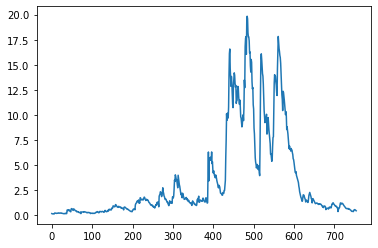

In [175]:
plt.plot(cov_JPM_KO_forcast)

In [162]:
# save variances
var_BAC_forcast = []
for t in range(1,N):
    var_BAC_forcast.append(forecastMatrix_eig[t][0][0])

var_JPM_forcast = []
for t in range(1,N):
    var_JPM_forcast.append(forecastMatrix_eig[t][1][1])

var_WFC_forcast = []
for t in range(1,N):
    var_WFC_forcast.append(forecastMatrix_eig[t][2][2])

df = pd.DataFrame(var_BAC_forcast)
df.to_csv('var_BAC_forcast_eigen.csv') 

df = pd.DataFrame(var_JPM_forcast)
df.to_csv('var_JPM_forcast_eigen.csv') 

df = pd.DataFrame(var_WFC_forcast)
df.to_csv('var_WFC_forcast.csv') 

## MVP

In [163]:
data_simple = np.array(pd.read_csv("returns_R_simple.csv")).T

In [164]:
weights_eigen = np.zeros((N,1,p))
min_port_ret = np.zeros((N,1))

ell = np.array(([1, 1, 1]))
for n in range(1,N):
    w = np.matmul(np.linalg.inv(forecastMatrix_eig[n]), ell)
    weights_eigen[n,:,:] = w/sum(w)
    min_port_ret[n] = np.sum((np.multiply(weights_eigen[n,:,:], data_simple[:,1505+n])),axis=1)
    

In [165]:
df = pd.DataFrame((min_port_ret))
df.to_csv('MVP_eigen.csv') 

In [166]:
mean_min = np.mean(min_port_ret)*np.sqrt(250)
std_min = np.std(min_port_ret)*np.sqrt(250)
sharpe_ratio_min = mean_min/std_min
print(mean_min, std_min, sharpe_ratio_min)

0.7470433110492135 25.66213921115525 0.02911071851424125


In [167]:
df = pd.DataFrame(weights_eigen.T[0].T)
df.to_csv('weights_eigen_0.csv') 

## WEEKLY

In [168]:
# Use the exact same data as in R, for the DCC and GO-GARCH model
data_forecast = data

In [169]:
# Number of loops in forecast
p = 3
N = 756

# Create covariance matrix container
min_port_ret = np.zeros((N,1))

In [173]:
for n in range(0,N-1,5):
    # Move estimation window by 5
    X = data_forecast[:,n:1506+n]
    print(n, "out of", N, "in Eigen-GARCH forecasting")
    # Generate new lambdas for likelihood estimation
    lambdas_eig = np.tile(np.linalg.eig(np.cov(X.T, rowvar=False))[0], (T,1))
    
    # Use prior estimation results as starting values
    startingVals_eig = list(estimation.x)
    
    # Arguments
    arguments_eig = (np.asarray(X), lambdas_eig)
    
    # Estimation
    estimation = minimize(Eigen_GARCH.eigenLikelihood, x0=startingVals_eig , args=arguments_eig , method="SLSQP", bounds=bnds_eig, options={"maxiter":100000, "ftol":10e-24})
    
    # Save parameters
    phi1, phi2, phi3, w1, w2, w3, a11, a12, a13, a21, a22, a23, a31, a32, a33, b11, b12, b13, b21, b22,b23, b31, b32,b33 = estimation.x
 
    W_eig = np.array(([w1, w2, w3]))
    A_eig = np.array(([a11, a12,a13],
                  [a21, a22,a23],
                  [a31, a32,a33]))
    B_eig = np.array(([b11, b12,b13],
                  [b21, b22,b23],
                  [b31, b32,b33]))
    V_eig = np.array(([np.cos(phi1), np.sin(phi1),0],[-np.sin(phi1), np.cos(phi1),0 ], [0, 0,1 ])
                    )@ np.array(([np.cos(phi2), 0, np.sin(phi2)], [0, 1,0 ], [-np.sin(phi2), 0, np.cos(phi2)])
                           )@ np.array(( [1, 0,0 ], [0,np.cos(phi3), np.sin(phi3)], [0,-np.sin(phi3), np.cos(phi3)]))

    Xtilde = V_eig.transpose() @ X
    T = 1506
    
    lambdas = (np.ones((k,T))).transpose()
    condVar_eig = np.zeros((T,k,k))
    
    for t in range(1,T):
        lambdas[t] = W_eig+np.concatenate(A_eig @ np.multiply(Xtilde[:,t-1:t],Xtilde[:,t-1:t]), axis=0 )+ B_eig @ lambdas[t-1]
        condVar_eig[t] = V_eig @ np.diag(lambdas[t]) @ V_eig.T
         
    # Store 5-step forecast     
    #1
    lambdas_f = W_eig + (A_eig @ np.multiply(Xtilde[:,T-1], Xtilde[:,T-1]))+ B_eig @ lambdas[T-1]
    forecastMatrix_eig_1 = V_eig @ np.diag(lambdas_f) @ V_eig.T
    
    #2
    lambdas_f = W_eig + (A_eig @ np.multiply(Xtilde[:,T-1], Xtilde[:,T-1]))+ B_eig @ lambdas_f
    forecastMatrix_eig_2 = V_eig @ np.diag(lambdas_f) @ V_eig.T
    
    #3
    lambdas_f = W_eig + (A_eig @ np.multiply(Xtilde[:,T-1], Xtilde[:,T-1]))+ B_eig @ lambdas_f
    forecastMatrix_eig_3 = V_eig @ np.diag(lambdas_f) @ V_eig.T
    
    #4
    lambdas_f = W_eig + (A_eig @ np.multiply(Xtilde[:,T-1], Xtilde[:,T-1]))+ B_eig @ lambdas_f
    forecastMatrix_eig_4 = V_eig @ np.diag(lambdas_f) @ V_eig.T
    
    #5
    lambdas_f = W_eig + (A_eig @ np.multiply(Xtilde[:,T-1], Xtilde[:,T-1]))+ B_eig @ lambdas_f
    forecastMatrix_eig_5 = V_eig @ np.diag(lambdas_f) @ V_eig.T
    
    # Total
    forecastMatrix_eig_weekly = forecastMatrix_eig_1 +forecastMatrix_eig_2+forecastMatrix_eig_3+forecastMatrix_eig_4+forecastMatrix_eig_5
    
    #MVP
    ell = np.array(([1, 1, 1]))

    w = np.matmul(np.linalg.inv(forecastMatrix_eig_weekly), ell)
    w_weekly = w/sum(w)
    min_port_ret[n+1] = np.sum((np.multiply(w_weekly, data_simple[:,1506+n].T)))
    min_port_ret[n+2] = np.sum((np.multiply(w_weekly, data_simple[:,1506+n+1].T)))
    min_port_ret[n+3] = np.sum((np.multiply(w_weekly, data_simple[:,1506+n+2].T)))
    min_port_ret[n+4] = np.sum((np.multiply(w_weekly, data_simple[:,1506+n+3].T)))
    min_port_ret[n+5] = np.sum((np.multiply(w_weekly, data_simple[:,1506+n+4].T)))


0 out of 756 in Eigen-GARCH forecasting
5 out of 756 in Eigen-GARCH forecasting
10 out of 756 in Eigen-GARCH forecasting
15 out of 756 in Eigen-GARCH forecasting
20 out of 756 in Eigen-GARCH forecasting
25 out of 756 in Eigen-GARCH forecasting
30 out of 756 in Eigen-GARCH forecasting
35 out of 756 in Eigen-GARCH forecasting
40 out of 756 in Eigen-GARCH forecasting
45 out of 756 in Eigen-GARCH forecasting
50 out of 756 in Eigen-GARCH forecasting
55 out of 756 in Eigen-GARCH forecasting
60 out of 756 in Eigen-GARCH forecasting
65 out of 756 in Eigen-GARCH forecasting
70 out of 756 in Eigen-GARCH forecasting
75 out of 756 in Eigen-GARCH forecasting
80 out of 756 in Eigen-GARCH forecasting
85 out of 756 in Eigen-GARCH forecasting
90 out of 756 in Eigen-GARCH forecasting
95 out of 756 in Eigen-GARCH forecasting
100 out of 756 in Eigen-GARCH forecasting
105 out of 756 in Eigen-GARCH forecasting
110 out of 756 in Eigen-GARCH forecasting
115 out of 756 in Eigen-GARCH forecasting
120 out of 756

In [171]:
df = pd.DataFrame((min_port_ret))
df.to_csv('MVP_eigen_week.csv')

In [34]:
mean_min = np.mean(min_port_ret)*np.sqrt(250)
std_min = np.std(min_port_ret)*np.sqrt(250)
sharpe_ratio_min = mean_min/std_min
print(mean_min, std_min, sharpe_ratio_min)

0.645986644848357 26.73941774982465 0.024158590545697023
